In [6]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import argparse
import pandas as pd
from eofs.xarray import Eof
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns

from lwp_nd import lwp_nd_input_ICON
from PCA_radiances import PCA_calculation, variance_sklearn_plot, dataframe_csv #, convert_3D

from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, check_scoring, mean_squared_error

from sklearn import metrics

from skimage.metrics import structural_similarity as ssim

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os

import joblib
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor


def read_data_refl_emiss_rttov( rttov_path_rad, rttov_path_refl_emmis): #rttov_path
  
    #input: path of the radiances and reflectances
    #output: refl_emmiss CHxHxW  
    
    rttov_ds_rad = xr.open_dataset(rttov_path_rad).compute()  # write read rttov in a function
    rttov_ds_refl_emmi = xr.open_dataset(rttov_path_refl_emmis).compute()  
    
    
    # rttov_ds = xr.open_dataset(rttov_path).compute()        
    # rttov_variable = np.zeros((np.shape(rttov_ds['Radiance_total'].values)))
    rttov_variable = np.zeros((np.shape(rttov_ds_rad['Y'].values)))

    rttov_variable[:19] = rttov_ds_refl_emmi['bt_refl_total'][:19] #refl 1-19, 26 rad 20-25 and 27-36
    rttov_variable[19:25] = rttov_ds_rad['Y'][19:25]
    rttov_variable[25] = rttov_ds_refl_emmi['bt_refl_total'][19] #solo tengo en este archivo 1-19,26 luego tengo q hacer todo esto en un solo file
    rttov_variable[26:36] = rttov_ds_rad['Y'][26:36]

#     rttov_variable[:19] = rttov_ds['BRF_total'][:19] #refl 1-19, 26 rad 20-25 and 27-36
#     rttov_variable[19:25] = rttov_ds['Radiance_total'][19:25]
#     rttov_variable[25] = rttov_ds['BRF_total'][25] #solo tengo en este archivo 1-19,26 luego tengo q hacer todo esto en un solo file
#     rttov_variable[26:36] = rttov_ds['Radiance_total'][26:36]
    
    print("===================================== Training output ====================================== ")
    print("****************variables shape training_output", np.shape(rttov_variable))
    
    # rttov_ds.close()
    # rttov_variable_ds = xr.DataArray( rttov_variable, dims=['channel','lat','lon'], coords= [rttov_ds.Channel.data, rttov_ds.Latitude.data, rttov_ds.Longitude.data])      

    rttov_ds_rad.close()
    rttov_ds_refl_emmi.close()
    rttov_variable_ds = xr.DataArray( rttov_variable[:,9:,], dims=['channel','lat','lon'], coords= [rttov_ds_rad.chan.data, rttov_ds_refl_emmi.lat.data[9:], rttov_ds_refl_emmi.lon.data ])

    
    return  rttov_variable_ds  
   
 
def get_split_data_xarray(path_ICON, path_output, k_fold, rttov_path_rad, rttov_path_refl_emmis): #rttov_path
    '''
    Input: path of the x  and y  (x = ICON-LES, y = RTTOV-radiances/reflectances)
           path_ICON:
                   x: 3D variables height: 150, lat: 628, lon: 589
                      2D variables lat: 628, lon: 589
           rttov_path_rad, rttov_path_refl_emmis:
                   y: 3D variables Channel: 36, Latitude: 628, Longitude: 589
                      reflectances: 1-19,26  Channel  
                      radiances: 20-25,27-36 Channel 
           path_output: path in which the output will be saved

    Output:
    
    dataframes 
    x_train_2D, x_train_3D (height, lat, lon) = ICON-LES lat < threshold
    x_test_2D, x_test_3D (height, lat, lon) =  ICON-LES lat > threshold
    y_train, y_test (channel: 36, Latitude, Longitude)  = radiances/reflectances 
    df_x_train, df_x_test: dataframes of the ICON-LES inputs
                           dataframe 2D variables (row: lat x lon(H*W))
                           dataframe 3D variables (row: lat x lon(H*W), columns(height))
    df_y_train, df_y_test: dataframes of the reflectances/radiances
                           dataframe variables (row: Latitude x Longitude(H*W), columns(channel))

    '''
    ds = xr.open_dataset(path_ICON).compute()
    # rttov_variable_ds = read_data_refl_emiss_rttov(rttov_path)
    rttov_variable_ds = read_data_refl_emiss_rttov(rttov_path_rad, rttov_path_refl_emmis)

    #================================= X ========================================
    # ################### K folds ###############################
    if (k_fold == 5):
        ds_x_train = ds.sel(lat=slice(48.97, 54.47))
        ds_x_test = ds.sel(lat=slice(47.5, 48.97) )
        
        y_train = rttov_variable_ds.sel(lat=slice(48.97, 54.47) ) #(0,53)) 
        y_test = rttov_variable_ds.sel(lat=slice(47.5, 48.97)) #(53.01, 60)) 
    
    elif (k_fold == 4):
        ds_x_train = xr.concat([ds.sel(lat=slice(47.5, 48.97)), ds.sel(lat=slice(50.34, 54.47))], dim="lat")
        ds_x_test = ds.sel(lat=slice(48.97, 50.34))

        y_train = xr.concat([rttov_variable_ds.sel(lat=slice(47.5, 48.97)), rttov_variable_ds.sel(lat=slice(50.34, 54.47))], dim="lat")  
        y_test = rttov_variable_ds.sel(lat=slice(48.97, 50.34)) #(53.01, 60))  
   
    elif (k_fold == 3):      
        ds_x_train = xr.concat([ds.sel(lat=slice(47.5, 50.34)), ds.sel(lat=slice(51.72, 54.47))], dim="lat")
        ds_x_test = ds.sel(lat=slice(50.34, 51.72))
         
        y_train = xr.concat([rttov_variable_ds.sel(lat=slice(47.5, 50.34)), rttov_variable_ds.sel(lat=slice(51.72, 54.47))], dim="lat") 
        y_test = rttov_variable_ds.sel(lat=slice(50.34, 51.72)) #(53.01, 60))  
    
    elif (k_fold == 2):
        ds_x_train = xr.concat([ds.sel(lat=slice(47.5, 51.72)), ds.sel(lat=slice(53.09, 54.47))], dim="lat")
        ds_x_test = ds.sel(lat=slice(51.72, 53.09))
        
        y_train = xr.concat([rttov_variable_ds.sel(lat=slice(47.5, 51.72)), rttov_variable_ds.sel(lat=slice(53.09, 54.47))], dim="lat") 
        y_test = rttov_variable_ds.sel(lat=slice(51.72, 53.09)) #(53.01, 60))  
    
    elif (k_fold == 1):
        ds_x_train = ds.sel(lat=slice(47.5, 53.09))
        ds_x_test = ds.sel(lat=slice(53.09, 54.47) )
    
        y_train = rttov_variable_ds.sel(lat=slice(47.5, 53.09) ) #(0,53)) 
        y_test = rttov_variable_ds.sel(lat=slice(53.09, 54.47)) #(53.01, 60)) 
    
    
    ds.close()
    #================================= X ========================================    
 
    
    lat_test_ds = y_test.lat
    lon_test_ds = y_test.lon

    
        
    # df_x_train.drop(df_x_train[(df_x_train['Nd_max'] <400) & (df_x_train['lwp'] < 600)].index, inplace=True)
   
    #=============================Dataframe X  ====================================    
    x_train_2D = { "Nd_max": np.log(ds_x_train.Nd_max.values+ 1.0e-16), "lwp": np.log(ds_x_train.lwp.values+ 1.0e-16)}  
    x_train_3D = { "pres": ds_x_train.pres.values, "ta": ds_x_train.ta.values, "hus": ds_x_train.hus.values}
    

    x_test_2D = { "Nd_max": np.log(ds_x_test.Nd_max.values+ 1.0e-16), "lwp": np.log(ds_x_test.lwp.values+ 1.0e-16)}  
    x_test_3D = { "pres": ds_x_test.pres.values, "ta": ds_x_test.ta.values, "hus": ds_x_test.hus.values}
    
    
    ds_x_train.close()
    ds_x_test.close()
    
    #=============================Dataframe X  ====================================    
    df_x_train = pd.DataFrame()
    df_x_test = pd.DataFrame()
    
    for key, var in x_train_2D.items():  
        df = pd.DataFrame(data = var.flatten()
             , columns =  [key])
        df_x_train = pd.concat([df_x_train, df], axis=1)   
    for key, var in x_train_3D.items():  
        var = var.transpose(1,2,0) #lat,lot,heigh
        var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
        var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
        df_x_train=pd.concat([df_x_train, var_df], axis=1)
    
    print("=================== Dataframe training =======================================")    
    name_file = 'inputs_statistics_training'  
    df_x_train.describe().to_csv("{}/{}.csv".format(path_output, name_file))     
    
    for key, var in x_test_2D.items():  
        df = pd.DataFrame(data = var.flatten()
             , columns = [key])
        df_x_test = pd.concat([df_x_test, df], axis=1)   
    for key, var in x_test_3D.items():  
        var = var.transpose(1,2,0) #lat,lot,heigh
        var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
        var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
        df_x_test=pd.concat([df_x_test, var_df], axis=1)
        
    print("=================== Dataframe testing =======================================")    
    name_file = 'inputs_statistics_testing'  
    df_x_test.describe().to_csv("{}/{}.csv".format(path_output, name_file))    
    
    #================================= Y ========================================

    
    ###############################Dataframe Y_data##################################
    name_file = 'refl_emiss_statistics'
    df_y = dataframe_csv(variable = rttov_variable_ds.transpose('lat', 'lon', 'channel').values, 
                  column = rttov_variable_ds.channel.values,  
                  path_output = path_output, 
                  name_file = name_file)
    rttov_variable_ds.close()
           
    ############## convert img_rttov: because the input for the dataframe_csv need to be HxWxCH I use transpose ##########################
    name_file = 'refl_emiss_statistics_train'
    df_y_train = dataframe_csv(variable = y_train.transpose('lat', 'lon', 'channel').values, 
                  column = y_train.channel.values,  
                  path_output = path_output, 
                  name_file = name_file)
     
    
    # # df_y_train = preprocessing.normalize(df_y_train)

        
    name_file = 'refl_emiss_statistics_test'
    df_y_test = dataframe_csv(variable = y_test.transpose('lat', 'lon', 'channel').values, 
                  column = y_test.channel.values, 
                  path_output = path_output, 
                  name_file = name_file)
    
    # df_y_test = preprocessing.normalize(df_y_test)

    ###################################################################################
        

    y_train.close()
    y_test.close()
    
    return x_train_2D, x_train_3D, x_test_2D, x_test_3D, y_train, y_test,  df_x_train, df_x_test, df_y_train, df_y_test, lat_test_ds, lon_test_ds


    
def get_data_xarray(path_ICON, rttov_path_rad, rttov_path_refl_emmis, path_output):  #rttov_path
    '''
    Input: path of the x  and y  (x = ICON-LES, y = RTTOV-radiances/reflectances)
           path_ICON:
                   x: 3D variables height: 150, lat: 628, lon: 589
                      2D variables lat: 628, lon: 589
           rttov_path_rad, rttov_path_refl_emmis:
                   y: 3D variables Channel: 36, Latitude: 628, Longitude: 589
                      reflectances: 1-19,26  Channel  
                      radiances: 20-25,27-36 Channel 
           path_output: path in which the output will be saved

    Output:
    
    dataframes 
    df_x: dataframes of the ICON-LES inputs
                           dataframe 2D variables (row: lat x lon(H*W))
                           dataframe 3D variables (row: lat x lon(H*W), columns(height))
    df_y: dataframes of the reflectances/radiances
                           dataframe variables (row: Latitude x Longitude(H*W), columns(channel))

    '''
    ds = xr.open_dataset(path_ICON).compute()
    # rttov_variable_ds = read_data_refl_emiss_rttov(rttov_path)
    rttov_variable_ds = read_data_refl_emiss_rttov(rttov_path_rad, rttov_path_refl_emmis)

     
    lat_ds = rttov_variable_ds.lat
    lon_ds = rttov_variable_ds.lon
    
        
    # df_x_train.drop(df_x_train[(df_x_train['Nd_max'] <400) & (df_x_train['lwp'] < 600)].index, inplace=True)
   
    #=============================Dataframe X  ====================================    
    x_2D = { "Nd_max": np.log(ds.Nd_max.values+ 1.0e-16), "lwp": np.log(ds.lwp.values+ 1.0e-16)}  
    x_3D = { "pres": ds.pres.values, "ta": ds.ta.values, "hus": ds.hus.values}
    
    ds.close()
    #=============================Dataframe X  ====================================    
    df_x = pd.DataFrame()
    df_x = pd.DataFrame()
    
    for key, var in x_2D.items():  
        df = pd.DataFrame(data = var.flatten()
             , columns =  [key])
        df_x = pd.concat([df_x, df], axis=1)   
    for key, var in x_3D.items():  
        var = var.transpose(1,2,0) #lat,lot,heigh
        var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
        var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
        df_x=pd.concat([df_x, var_df], axis=1)
    
    print("=================== Dataframe training =======================================")    
    name_file = 'inputs_statistics_testing_img'  
    df_x.describe().to_csv("{}/{}.csv".format(path_output, name_file))     
    
        
    #================================= Y ========================================
    ###############################Dataframe Y_data##################################
    name_file = 'refl_emiss_statistics_testing_img'
    df_y = dataframe_csv(variable = rttov_variable_ds.transpose('lat', 'lon', 'channel').values, 
                  column = rttov_variable_ds.channel.values,  
                  path_output = path_output, 
                  name_file = name_file)
    rttov_variable_ds.close()
           
    return df_x, df_y, lat_ds, lon_ds


  
def scaler_PCA_input(df_x_train, path_output):
    '''
    input: dataframe input with 2D and 3D
    output: x_train_df dataframe with the variable 2D and 3D PCAs
    '''
    variables_2D = { "Nd_max", "lwp"}  
    n_pca_variables_3D = { "pres": 5, "ta": 10, "hus":24} #(height, lat, lon)
    training_df_x_train = pd.DataFrame()

    scaler = preprocessing.StandardScaler().fit(df_x_train)   
    df = pd.DataFrame(scaler.transform(df_x_train), columns = df_x_train.columns) 

    print("=================== After scaler dataframe training saved=======================================")    
    name_file = 'after_scaler_inputs_statistics_training'  
    df.describe().to_csv("{}/{}.csv".format(path_output, name_file))     
    
  
    
    pca_3D = {}
    
    for key in variables_2D: 
        training_df_x_train=pd.concat([training_df_x_train, df[key]], axis=1)

    for key, var in n_pca_variables_3D.items():  
        var_scaled = df.filter(like=key)                 
        n_pca = var 
        name_plot= "{}_Explained_variance_{}_variable".format(n_pca, key)
        print("============== Variable: {}  ========================================".format(key))
        X_pca, pca = PCA_calculation(var_scaled.to_numpy(), name_plot,n_pca, path_output)
        #pca_3D.append(pca)
        pca_3D[key] = pca

        # print( 'Original shape: {}'.format(str(PC.shape)))
        print( 'Original shape: {}'.format(str(var_scaled.shape)))
        print( 'Reduced shape: {}'.format(str(X_pca.shape)))
        principalDf = pd.DataFrame(data = X_pca
             , columns = [f"{key}_PCA_{i}" for i in range(n_pca)])
        training_df_x_train = pd.concat([training_df_x_train, principalDf], axis=1)

    print("================ dataframe all after PCA saved=============================")
    training_df_x_train.describe().to_csv(path_output + "/inputs_after_PCA_StandardScaler.csv")    
    # count_nan 
    count_nan_in_df = training_df_x_train.isnull().sum()
    print("================ values of Nan in training_input_variables_df =====================")
    print (count_nan_in_df)  #can i used 0 in the lwp and nd?


    return training_df_x_train, scaler, pca_3D, n_pca_variables_3D


def PCA_read_input_target(df_y_train, path_output):
    '''
    PC_output (latxlon, number_pcs)
    '''
###########################################
    df_y_train_normalized = preprocessing.normalize(df_y_train)
###########################################3

    scaler_y = preprocessing.StandardScaler().fit(df_y_train_normalized)  #Standardize features by removing the mean and scaling to unit variance
    X_scaled = scaler_y.transform(df_y_train_normalized)

    ###### analysis  PCA###########################
    name_plot= "Explained_variance_refl_emiss"
    n_pca = 6 
    n_bands = len(df_y_train.columns) # rttov_bands) #2 #test JQ     
    X_reduced_output, pca_y = PCA_calculation(X_scaled, name_plot, n_pca, path_output) #PC_output_all

    principalDf = pd.DataFrame(data = X_reduced_output
             , columns = [f"PCA_{i}" for i in range(np.shape(X_reduced_output)[1])], index = df_y_train.index)
    print("columns output", principalDf.columns)
        
    print("=================== After scaler and pca output training Dataframe =======================================")   
    name_file = 'after_scaler_pca_output_statistics_training'  
    principalDf.describe().to_csv("{}/{}.csv".format(path_output, name_file)) 
    
    
    return scaler_y, principalDf, pca_y



    
##################### 
def get_test_input(path_output, df_x_test, scaler, pca_3D, n_pca_variables_3D):
    '''
    PC_output (latxlon, number_pcs)
    '''
    testing_df_x_test = pd.DataFrame()
    
    variables_2D = { "Nd_max", "lwp"}  
    # variables_3D = { "pres", "ta", "hus"} 

        
    df = pd.DataFrame(scaler.transform(df_x_test), columns = df_x_test.columns) 
    
    print("=================== After scaler Dataframe testing =======================================")    
    name_file = 'after_scaler_inputs_statistics_testing'  
    df.describe().to_csv("{}/{}.csv".format(path_output, name_file))  
    
    
    for key in variables_2D: 
        testing_df_x_test=pd.concat([testing_df_x_test, df[key]], axis=1)

        
    for key in n_pca_variables_3D:  
        var_scaled = df.filter(like=key)   
        principalDf = pd.DataFrame(data = pca_3D[key] .transform(var_scaled.to_numpy()) #pca_3D [i] i de 1 
             , columns = [f"{key}_PCA_{i}" for i in range(n_pca_variables_3D[key])])
        testing_df_x_test = pd.concat([testing_df_x_test, principalDf], axis=1)
   
    return testing_df_x_test


def get_test_output(df, path_output, scaler, pca):

############################################333    
    df_normalized = preprocessing.normalize(df)
###########################################3
    # test_scaled= scaler.transform(df)
    test_scaled= scaler.transform(df_normalized)

    test_pca = pca.transform(test_scaled)
    
    print(np.shape(test_pca))
    test_df = pd.DataFrame(data = test_pca
             , columns = [f"PCA_{i}" for i in range(np.shape(test_pca)[1])])
    
    print("=================== After scaler and pca output testing Dataframe =======================================")   
    name_file = 'after_scaler_pca_output_statistics_testing'  
    test_df.describe().to_csv("{}/{}.csv".format(path_output, name_file)) 
    
        
    return test_df

def test_random_forest(train_x, train_y, test_x, test_y):
                                     
    rf_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      #min_impurity_split=None, min_samples_leaf=1,
                      min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)                                      
    rf_pcs = rf_model.fit(train_x, train_y)
    
    return rf_pcs

def from2to3d(x, lat_ds, lon_ds):
    print(np.shape(x))
    columns = np.shape(x)[1]
    x_3d = np.zeros((columns, len(lat_ds) , len(lon_ds))) # 628,589)) 

    for i in range(columns):
        x_3d[i,:,:] = x[:,i].reshape(-1, len(lon_ds))
        
    return x_3d  
 
def from1to2d(x, lat_ds, lon_ds):
    print(np.shape(x))

    x_2d = np.zeros((len(lat_ds) , len(lon_ds))) # 628,589)) 

    x_2d[:,:] = x.reshape(len(lat_ds) , len(lon_ds))
        
            
    return x_2d 

# def plot_target_prediction(target,lat_ds, lon_ds, prediction, path_output, name_plot):
#     n_img = len(target)
#     fig = plt.figure(figsize=(5 * n_img, 2 * 2 ),facecolor = 'white')  #WxH
    
#     fig.suptitle("Comparation between target and prediction", fontsize = 24)

#     x = lon_ds #.values  
#     y = lat_ds #.values
    
#     for i in range(n_img):

#         axes = plt.subplot(2,n_img, i + 1)
#         # ctr = axes.pcolormesh(x, y,prediction[i],cmap = "cividis",shading='auto')
#         ctr = axes.pcolormesh(x, y,prediction,cmap = "cividis",shading='auto')

#         axes.set_title(f"Prediction PC_{i}",fontsize=14)
#         plt.colorbar(ctr)
        
#         # Target
#         axes0 = plt.subplot(2,n_img, i + 1 + n_img)
#         # ctr = axes0.pcolormesh(x, y,target[i],cmap = "cividis",shading='auto')
#         ctr = axes0.pcolormesh(x, y,target,cm
#         # Emulatorap = "cividis",shading='auto')
#         axes0.set_title(f"Target PC_{i}",fontsize=14)

#         plt.colorbar(ctr)
#     plt.tight_layout() #para q no queden muchos borde blanco

def plot_target_prediction(ds_out, path_output, name_plot):

    # n_channels = len(output_ds)
    # n_channels
    f, axes = plt.subplots(1, 2, figsize=(4*2, 1*4*1.066)) #width of 15 inches and 7 inches in height.
    f.subplots_adjust(wspace=0.4, hspace=0.4)

    axli = axes.ravel()

    # for i in n_channels:
    ds_out['target'].plot(ax = axli[0] )#, vmin=0, vmax=0.12, cmap='jet')
    ds_out['prediction'].plot(ax = axli[1])#, vmin=0, vmax=0.12, cmap='jet')# cmap='cividis', 

    plt.suptitle("ssim: " + str(ssim(ds_out['target'], ds_out['prediction'])) + " rmse: " + str(mean_squared_error(ds_out['target'], ds_out['prediction'])))

    figure_name = '{}/{}.png'.format(path_output, name_plot) #aca pasarr con todo path
     
    f.tight_layout()

    f.savefig(figure_name) 
    plt.close() 
    
    
def metric_calculation(x_train, y_train, x_test, y_test, model, name_model):
    gt =  y_train 
    pred = model.predict(x_train)
    print("*************************** Results of the model {} *********************************".format(name_model))

    print("========================= Training metrics ==========================") 
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(gt, pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(gt, pred))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(gt, pred)))
    mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
    print('Mean Absolute Percentage Error (MAPE): \n', round(mape * 100, 2))
    print('Accuracy: \n', round(100*(1 - mape), 2))

    
    print("========================= Testing metrics ==========================") 
    gt =  y_test 
    pred = model.predict(x_test)
 
    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(gt, pred))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(gt, pred))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(gt, pred)))
    mape = np.mean(np.abs((gt - pred) / np.abs(gt)))
    print('Mean Absolute Percentage Error (MAPE): \n', round(mape * 100, 2))
    print('Accuracy: \n', round(100*(1 - mape), 2))


    score = model.score(x_train, y_train)
    print('score in training:', score)  
    score = model.score(x_test, y_test)
    print('score in testing:', score)    
    

In [7]:
path_dataset="/work/bb1036/b381362/dataset" 
path_out="/home/b/b381362/output"   

path_ICON = path_dataset + "/data_rttov_T12_dropupbottom_Reff.nc"

k_fold = 2
name_PCA = 'PCA_0'

rttov_path_refl_emmis = path_out+ "/output-rttov/rttov-131-data-icon-1to19-26-T12.nc"
rttov_path_rad = path_out + "/output-rttov/rttov-13-data-icon-1-to-36-not-flip.nc"

rttov_path = "/work/bb1036/rttov_share/rttov-131-36-channels-05022013-07182022.nc"
        
path_rttov_test = path_out + "/output-rttov/rttov-131-data-icon-1to36-T09.nc"
path_ICON_test = "/home/jvillarreal/Documents/phd/dataset/data_rttov_T09_dropupbottom_Reff.nc"

path_out="/home/b/b381362/output/ML_output"       

In [3]:
ds = xr.open_dataset(path_ICON)
ds

<xarray.Dataset>
Dimensions:       (lat: 628, lon: 589, height: 150)
Coordinates:
  * height        (height) float64 1.0 2.0 3.0 4.0 ... 147.0 148.0 149.0 150.0
  * lat           (lat) float64 47.6 47.61 47.62 47.63 ... 54.47 54.48 54.5
  * lon           (lon) float64 4.5 4.517 4.534 4.551 ... 14.45 14.46 14.48 14.5
Data variables: (12/20)
    FR_LAND       (lat, lon) float32 ...
    clc           (height, lat, lon) float32 ...
    cli           (height, lat, lon) float32 ...
    clw           (height, lat, lon) float32 ...
    clwvi         (lat, lon) float32 ...
    hus           (height, lat, lon) float32 ...
    ...            ...
    u_10m         (lat, lon) float32 ...
    v_10m         (lat, lon) float32 ...
    lwp           (lat, lon) float32 ...
    Nd_max        (lat, lon) float64 ...
    Nd            (height, lat, lon) float64 ...
    Reff          (height, lat, lon) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.4
    uuidOfVGrid:  3be5ac35-92f4-4e91-7418-b62336222e20
    title:        ICON simulation
    history:      Sun Jun 19 21:06:20 2022: ncks -d lat,47.599,54.5 /work/bb1...
    references:   see MPIM/DWD publications
    comment:      HDCP2 Sammelaccount (k203095) on m21726 (Linux 2.6.32-696.1...
    NCO:          netCDF Operators version 5.0.6 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [ ]:
x_train_2D = { "Nd_max": np.log(ds_x_train.Nd_max.values+ 1.0e-16), "lwp": np.log(ds_x_train.lwp.values+ 1.0e-16), "v_10m": ds_x_train.v_10m.values}  
x_train_3D = { "clc": ds_x_train.cli.values, "cli": ds_x_train.clc.values, "clw": ds_x_train.clw.values, "hus": ds_x_train.hus.values}

In [20]:
df_2d_3d = ds.drop("clwvi").to_dataframe()

In [21]:
df_2d_3d.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


,FR_LAND,clc,cli,clw,hus,huss,pres,ps,qnc,t_s,ta,tas,topography_c,u_10m,v_10m,lwp,Nd_max,Nd,Reff
FR_LAND,1.0,0.013,0.021,0.022,0.098,0.51,-0.0064,-0.35,0.019,0.73,0.018,0.73,0.32,0.48,0.5,0.082,0.11,0.02,0.033
clc,0.013,1.0,0.34,0.34,0.047,0.082,0.041,-0.12,0.34,-0.073,0.018,-0.054,0.12,0.1,-0.016,0.16,0.14,0.33,0.29
cli,0.021,0.34,1.0,-0.0084,-0.052,0.1,-0.032,-0.15,-0.011,0.027,-0.029,0.04,0.15,0.08,0.021,0.0037,-0.032,-0.012,0.031
clw,0.022,0.34,-0.0084,1.0,0.19,0.00098,0.13,-0.0037,0.6,-0.05,0.13,-0.039,0.0054,0.019,0.0081,0.24,0.13,0.6,0.5
hus,0.098,0.047,-0.052,0.19,1.0,0.16,0.85,-0.12,0.19,0.094,0.85,0.11,0.11,0.12,0.081,0.043,0.036,0.19,-0.0038
huss,0.51,0.082,0.1,0.00098,0.16,1.0,-0.015,-0.75,-0.025,0.66,0.029,0.68,0.71,0.69,0.48,-0.03,-0.12,-0.022,0.18
pres,-0.0064,0.041,-0.032,0.13,0.85,-0.015,1.0,0.021,0.14,-0.0076,0.98,-0.0072,-0.022,-0.012,-0.008,0.0015,0.005,0.14,-0.18
ps,-0.35,-0.12,-0.15,-0.0037,-0.12,-0.75,0.021,1.0,0.035,-0.39,-0.02,-0.38,-1.0,-0.59,-0.39,0.036,0.18,0.034,-0.24
qnc,0.019,0.34,-0.011,0.6,0.19,-0.025,0.14,0.035,1.0,-0.073,0.13,-0.061,-0.034,0.014,-0.014,0.15,0.19,1.0,-0.28
t_s,0.73,-0.073,0.027,-0.05,0.094,0.66,-0.0076,-0.39,-0.073,1.0,0.022,0.97,0.34,0.46,0.52,-0.22,-0.28,-0.071,0.13


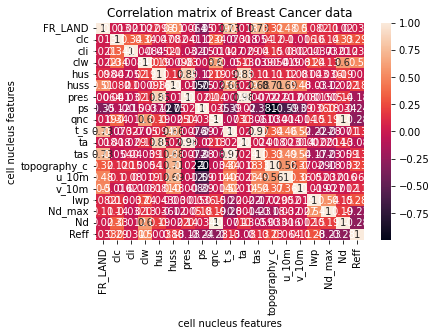

In [22]:
correlation_mat = df_2d_3d.corr()#.style.format("{:.2}") #.background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

sns.heatmap(correlation_mat, annot = True)

plt.title("Correlation matrix of Breast Cancer data")

plt.xlabel("cell nucleus features")

plt.ylabel("cell nucleus features")

plt.savefig("breast_cancer_correlation.png")

In [24]:
# #Correlation with output variable
# cor_target = abs(cor["MEDV"])

# #Selecting highly correlated features
# relevant_features = cor_target[cor_target>0.5]
# relevant_features

In [25]:
"clwvi", "qnc", "Nd", "Reff"

('clwvi', 'qnc', 'Nd', 'Reff')

In [ ]:
ds = ds.assign(ps = ds.ps/100, topography_c = ds.topography_c/1000)
# ds = ds.assign(ps = ds.ps/100, topography_c = topography_c/1000)


# Checking data 2D

In [4]:
ds_2d = ds.drop_dims("height")
df_2d = ds_2d.drop("clwvi").to_dataframe()

In [5]:
df_2d.shape

(369892, 10)

In [27]:
# df_2d

In [28]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_2d.describe().T

,count,mean,std,min,25%,50%,75%,max
FR_LAND,369892.000,0.899,0.301,0.000,1.000,1.000,1.000,1.000
huss,369892.000,0.007,0.002,0.002,0.006,0.007,0.009,0.012
ps,369892.000,99470.305,2948.344,77169.555,97330.006,100033.609,102022.258,103735.844
t_s,369892.000,290.125,4.564,275.645,287.594,291.184,293.524,303.966
tas,369892.000,288.105,3.457,277.876,286.406,288.872,290.579,298.220
topography_c,369892.000,237.324,237.265,-137.107,30.457,174.552,396.660,2319.548
u_10m,369892.000,-1.590,2.140,-9.650,-2.963,-1.436,-0.070,8.834
v_10m,369892.000,-2.118,1.884,-11.074,-3.245,-2.025,-0.862,8.305
lwp,369892.000,62.101,126.287,0.000,0.000,2.493,70.505,4600.840
Nd_max,369892.000,114.662,170.232,0.000,0.000,15.016,194.732,3446.759


In [29]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_2d.describe().T

,count,mean,std,min,25%,50%,75%,max
FR_LAND,369892.000,0.899,0.301,0.000,1.000,1.000,1.000,1.000
huss,369892.000,0.007,0.002,0.002,0.006,0.007,0.009,0.012
ps,369892.000,99470.305,2948.344,77169.555,97330.006,100033.609,102022.258,103735.844
t_s,369892.000,290.125,4.564,275.645,287.594,291.184,293.524,303.966
tas,369892.000,288.105,3.457,277.876,286.406,288.872,290.579,298.220
topography_c,369892.000,237.324,237.265,-137.107,30.457,174.552,396.660,2319.548
u_10m,369892.000,-1.590,2.140,-9.650,-2.963,-1.436,-0.070,8.834
v_10m,369892.000,-2.118,1.884,-11.074,-3.245,-2.025,-0.862,8.305
lwp,369892.000,62.101,126.287,0.000,0.000,2.493,70.505,4600.840
Nd_max,369892.000,114.662,170.232,0.000,0.000,15.016,194.732,3446.759


In [30]:
df_2d.isnull().sum()

FR_LAND         0
huss            0
ps              0
t_s             0
tas             0
topography_c    0
u_10m           0
v_10m           0
lwp             0
Nd_max          0
dtype: int64

In [32]:
# plot correlation heatmap to find out correlations

df_2d.corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)



,FR_LAND,huss,ps,t_s,tas,topography_c,u_10m,v_10m,lwp,Nd_max
FR_LAND,1.0,0.506,-0.3491,0.7342,0.7309,0.3156,0.4824,0.5001,0.0818,0.1107
huss,0.506,1.0,-0.7514,0.6556,0.6821,0.7099,0.6903,0.4818,-0.02983,-0.1219
ps,-0.3491,-0.7514,1.0,-0.3902,-0.3845,-0.9973,-0.5937,-0.3936,0.03565,0.1828
t_s,0.7342,0.6556,-0.3902,1.0,0.9725,0.3395,0.4615,0.525,-0.2166,-0.2802
tas,0.7309,0.6821,-0.3845,0.9725,1.0,0.3292,0.4883,0.5387,-0.168,-0.2284
topography_c,0.3156,0.7099,-0.9973,0.3395,0.3292,1.0,0.5621,0.3681,-0.02941,-0.1782
u_10m,0.4824,0.6903,-0.5937,0.4615,0.4883,0.5621,1.0,0.3588,0.05166,0.03185
v_10m,0.5001,0.4818,-0.3936,0.525,0.5387,0.3681,0.3588,1.0,0.01915,-0.02686
lwp,0.0818,-0.02983,0.03565,-0.2166,-0.168,-0.02941,0.05166,0.01915,1.0,0.5436
Nd_max,0.1107,-0.1219,0.1828,-0.2802,-0.2284,-0.1782,0.03185,-0.02686,0.5436,1.0


In [33]:
d =list(df_2d.columns.values)
# d.append("Nd")
d.append("clwvi")

df_3d = ds.drop_vars(d).to_dataframe()

In [34]:
df_3d

clc   cli   clw   hus       pres   qnc      ta    Nd  \
height  lat    lon                                                             
1.000   47.599 4.500  0.000 0.000 0.000 0.000   4960.944 0.000 218.011 0.000   
               4.517  0.000 0.000 0.000 0.000   4961.711 0.000 218.040 0.000   
               4.534  0.000 0.000 0.000 0.000   4961.422 0.000 218.066 0.000   
               4.551  0.000 0.000 0.000 0.000   4960.881 0.000 218.076 0.000   
               4.568  0.000 0.000 0.000 0.000   4960.745 0.000 218.066 0.000   
...                     ...   ...   ...   ...        ...   ...     ...   ...   
150.000 54.496 14.428 0.000 0.000 0.000 0.004 102564.117 0.000 279.591 0.000   
               14.445 0.000 0.000 0.000 0.004 102561.602 0.000 279.571 0.000   
               14.462 0.000 0.000 0.000 0.004 102562.758 0.000 279.507 0.000   
               14.479 0.000 0.000 0.000 0.004 102565.383 0.000 279.524 0.000   
               14.496 0.000 0.000 0.000 0.004 102563.547 0.000 279.801 0.000   

                       Reff  
height  lat    lon           
1.000   47.599 4.500    NaN  
               4.517    NaN  
               4.534    NaN  
               4.551    NaN  
               4.568    NaN  
...                     ...  
150.000 54.496 14.428   NaN  
               14.445   NaN  
               14.462   NaN  
               14.479   NaN  
               14.496   NaN  

[55483800 rows x 9 columns]

In [35]:
df_3d.corr().style.format("{:.3}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)


,clc,cli,clw,hus,pres,qnc,ta,Nd,Reff
clc,1.0,0.342,0.345,0.0471,0.041,0.338,0.0176,0.334,0.29
cli,0.342,1.0,-0.0084,-0.0517,-0.032,-0.0108,-0.0288,-0.0116,0.0312
clw,0.345,-0.0084,1.0,0.189,0.135,0.604,0.132,0.596,0.501
hus,0.0471,-0.0517,0.189,1.0,0.852,0.191,0.853,0.192,-0.00381
pres,0.041,-0.032,0.135,0.852,1.0,0.143,0.98,0.143,-0.176
qnc,0.338,-0.0108,0.604,0.191,0.143,1.0,0.134,0.998,-0.283
ta,0.0176,-0.0288,0.132,0.853,0.98,0.134,1.0,0.134,-0.0797
Nd,0.334,-0.0116,0.596,0.192,0.143,0.998,0.134,1.0,-0.283
Reff,0.29,0.0312,0.501,-0.00381,-0.176,-0.283,-0.0797,-0.283,1.0


In [ ]:
55483800

In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df_3d.describe().T

In [9]:
150*628*589

55483800

In [76]:
55483800 - 1548957

53934843

In [25]:
df_3d.columns

Index(['clc', 'cli', 'clw', 'hus', 'pres', 'qnc', 'ta', 'Reff'], dtype='object')

In [24]:
df_3d_flat = pd.DataFrame()

for key in df_3d.columns.values:  
    var = ds[key].values.transpose(1,2,0) #lat,lot,heigh
    var_df = pd.DataFrame(var.reshape(-1, var.shape[2]))
    var_df.columns = [f"{key}_{i}" for i in range(var.shape[2])]
    df_3d_flat=pd.concat([df_3d_flat, var_df], axis=1)

In [34]:
df_3d_flat.head(5)

,clc_0,clc_1,clc_2,clc_3,clc_4,clc_5,clc_6,clc_7,clc_8,clc_9,...,Reff_140,Reff_141,Reff_142,Reff_143,Reff_144,Reff_145,Reff_146,Reff_147,Reff_148,Reff_149
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
df_2d_flat = pd.DataFrame()

for key in df_2d.columns.values:  
    df = pd.DataFrame(data = ds[key].values.flatten()
             , columns =  [key])
    df_2d_flat = pd.concat([df_2d_flat, df], axis=1)   


In [48]:
df_2d_flat.head(5)

,FR_LAND,huss,ps,t_s,tas,topography_c,u_10m,v_10m,lwp,Nd_max
0,1.00000,0.00854,97263.15625,293.27359,290.38428,391.77109,-3.28142,-3.60881,0.00000,0.00000
1,1.00000,0.00866,97042.71094,293.37378,290.34625,411.24118,-2.99171,-2.78282,0.00000,0.00000
2,1.00000,0.00912,97138.87500,293.35953,289.46558,404.31824,-3.66209,1.21987,0.00000,0.00000
3,1.00000,0.00875,97430.73438,292.96747,289.51364,378.20941,-3.36742,2.16409,9.86312,12.24278
4,1.00000,0.00888,97264.65625,292.88342,289.86096,392.37076,-4.43084,1.12353,21.40899,22.19996


In [59]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df_2d_flat.describe().T

,count,mean,std,min,25%,50%,75%,max
FR_LAND,369892.00000,0.89941,0.30065,0.00000,1.00000,1.00000,1.00000,1.00000
huss,369892.00000,0.00726,0.00192,0.00159,0.00597,0.00743,0.00879,0.01210
ps,369892.00000,99470.30469,2948.34375,77169.55469,97330.00586,100033.60938,102022.25781,103735.84375
t_s,369892.00000,290.12537,4.56403,275.64502,287.59392,291.18404,293.52441,303.96646
tas,369892.00000,288.10510,3.45668,277.87640,286.40555,288.87213,290.57941,298.22034
topography_c,369892.00000,237.32391,237.26524,-137.10741,30.45731,174.55182,396.66014,2319.54810
u_10m,369892.00000,-1.58977,2.14049,-9.64963,-2.96348,-1.43616,-0.07018,8.83393
v_10m,369892.00000,-2.11791,1.88415,-11.07382,-3.24538,-2.02473,-0.86208,8.30486
lwp,369892.00000,62.10121,126.28691,0.00000,0.00000,2.49324,70.50479,4600.84033
Nd_max,369892.00000,114.66196,170.23196,0.00000,0.00000,15.01565,194.73238,3446.75921


In [43]:
df_2d

FR_LAND    huss           ps       t_s       tas  \
lat      lon                                                          
47.59900 4.50000   1.00000 0.00854  97263.15625 293.27359 290.38428   
         4.51700   1.00000 0.00866  97042.71094 293.37378 290.34625   
         4.53400   1.00000 0.00912  97138.87500 293.35953 289.46558   
         4.55100   1.00000 0.00875  97430.73438 292.96747 289.51364   
         4.56800   1.00000 0.00888  97264.65625 292.88342 289.86096   
...                    ...     ...          ...       ...       ...   
54.49600 14.42800  0.00000 0.00383 102688.92969 279.34561 279.46271   
         14.44500  0.00000 0.00405 102686.77344 279.33185 279.43817   
         14.46200  0.00000 0.00403 102688.00000 279.31967 279.41626   
         14.47900  0.00000 0.00397 102690.45312 279.30740 279.40302   
         14.49600  0.00000 0.00351 102688.75000 279.29285 279.52954   

                   topography_c    u_10m    v_10m      lwp    Nd_max  
lat      lon                                                          
47.59900 4.50000      391.77109 -3.28142 -3.60881  0.00000   0.00000  
         4.51700      411.24118 -2.99171 -2.78282  0.00000   0.00000  
         4.53400      404.31824 -3.66209  1.21987  0.00000   0.00000  
         4.55100      378.20941 -3.36742  2.16409  9.86312  12.24278  
         4.56800      392.37076 -4.43084  1.12353 21.40899  22.19996  
...                         ...      ...      ...      ...       ...  
54.49600 14.42800       0.00000 -3.71460 -2.36844  8.88930  61.92862  
         14.44500       0.00000 -3.98921 -2.28720  0.20539   8.55253  
         14.46200       0.00000 -4.06864 -2.37941 11.89317  90.85455  
         14.47900       0.00000 -4.05042 -2.40788 82.31301  99.56985  
         14.49600       0.00000 -3.90405 -2.56245 55.41874 183.17814  

[369892 rows x 10 columns]

In [60]:
df_flat=pd.concat([df_3d_flat, df_2d_flat], axis=1)

In [61]:
df_flat.head(5)

,clc_0,clc_1,clc_2,clc_3,clc_4,clc_5,clc_6,clc_7,clc_8,clc_9,...,FR_LAND,huss,ps,t_s,tas,topography_c,u_10m,v_10m,lwp,Nd_max
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00854,97263.15625,293.27359,290.38428,391.77109,-3.28142,-3.60881,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00866,97042.71094,293.37378,290.34625,411.24118,-2.99171,-2.78282,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00912,97138.87500,293.35953,289.46558,404.31824,-3.66209,1.21987,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00875,97430.73438,292.96747,289.51364,378.20941,-3.36742,2.16409,9.86312,12.24278
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00888,97264.65625,292.88342,289.86096,392.37076,-4.43084,1.12353,21.40899,22.19996


In [77]:
df = df_flat.loc[:, (df_flat != 0).any(axis=0)]
df

,clc_39,clc_40,clc_41,clc_42,clc_43,clc_44,clc_45,clc_46,clc_47,clc_48,...,FR_LAND,huss,ps,t_s,tas,topography_c,u_10m,v_10m,lwp,Nd_max
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00854,97263.15625,293.27359,290.38428,391.77109,-3.28142,-3.60881,0.00000,0.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00866,97042.71094,293.37378,290.34625,411.24118,-2.99171,-2.78282,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00912,97138.87500,293.35953,289.46558,404.31824,-3.66209,1.21987,0.00000,0.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00875,97430.73438,292.96747,289.51364,378.20941,-3.36742,2.16409,9.86312,12.24278
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00888,97264.65625,292.88342,289.86096,392.37076,-4.43084,1.12353,21.40899,22.19996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369887,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00383,102688.92969,279.34561,279.46271,0.00000,-3.71460,-2.36844,8.88930,61.92862
369888,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00405,102686.77344,279.33185,279.43817,0.00000,-3.98921,-2.28720,0.20539,8.55253
369889,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00403,102688.00000,279.31967,279.41626,0.00000,-4.06864,-2.37941,11.89317,90.85455
369890,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00397,102690.45312,279.30740,279.40302,0.00000,-4.05042,-2.40788,82.31301,99.56985


In [80]:
r = np.corrcoef(df_flat["ta_149"], df_flat["t_s"] )
r

array([[1.        , 0.93490582],
       [0.93490582, 1.        ]])

In [81]:
r = np.corrcoef(df_flat["hus_149"], df_flat["huss"] )
r

array([[1.       , 0.9933529],
       [0.9933529, 1.       ]])

In [82]:
r = np.corrcoef(df_flat["pres_149"], df_flat["ps"] )
r

array([[1.       , 0.9997966],
       [0.9997966, 1.       ]])

In [84]:
r = np.corrcoef(df_flat["ta_149"], df_flat["ps"] )
r

array([[ 1.        , -0.37514299],
       [-0.37514299,  1.        ]])

In [85]:
r = np.corrcoef(df_flat["ta_149"], df_flat["huss"] )
r

array([[1.        , 0.66970163],
       [0.66970163, 1.        ]])

In [86]:
r = np.corrcoef(df_flat["hus_149"], df_flat["ps"] )
r

array([[ 1.        , -0.75074353],
       [-0.75074353,  1.        ]])

In [87]:
r = np.corrcoef(df_flat["hus_149"], df_flat["t_s"] )
r

array([[1.        , 0.60673574],
       [0.60673574, 1.        ]])

In [88]:
r = np.corrcoef(df_flat["pres_149"], df_flat["t_s"] )
r

array([[ 1.        , -0.38961549],
       [-0.38961549,  1.        ]])

In [89]:
r = np.corrcoef(df_flat["pres_149"], df_flat["huss"] )
r

array([[ 1.        , -0.75082237],
       [-0.75082237,  1.        ]])

In [71]:
df_clc = df.filter(like="clc")   

In [74]:
count = (df_flat["clc_39"] != 0).sum()
count

28

In [73]:

count = (df_clc!= 0).sum()
count

clc_39        28
clc_40      5583
clc_41     29276
clc_42     47203
clc_43     61958
           ...  
clc_145     5174
clc_146     4231
clc_147     3441
clc_148     2759
clc_149     1953
Length: 111, dtype: int64

In [29]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df_2_3d_flat.describe().T

,count,mean,std,min,25%,50%,75%,max
clc_0,369892.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
clc_1,369892.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
clc_2,369892.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
clc_3,369892.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
clc_4,369892.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...
topography_c,369892.00000,237.32391,237.26524,-137.10741,30.45731,174.55182,396.66016,2319.54810
u_10m,369892.00000,-1.58977,2.14049,-9.64963,-2.96348,-1.43616,-0.07018,8.83393
v_10m,369892.00000,-2.11791,1.88415,-11.07382,-3.24538,-2.02473,-0.86208,8.30486
lwp,369892.00000,62.10121,126.28691,0.00000,0.00000,2.49324,70.50478,4600.84033


In [40]:
# df_2_3d_flat.corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)
# #

In [ ]:
df_3d_flat

In [ ]:
    name_column = "clw"
    i = 0
    
    
    # ax = plt.subplot(nrows, ncols, i + 1)
    name_column = df_3d.columns[i]
    x = df_3d[name_column]
    ax = sns.kdeplot(x, shade=True, color='gray') #
    ax.set_title(("Distribution of {} variable").format(name_column))
    #plt.show()

In [ ]:
n_var = len(df_3d.columns)
nrows = 3
ncols = n_var // nrows + (n_var % nrows > 0)

#fig,axes = plt.subplots(nrows,ncols) #,figsize = (32,20))
fig = plt.figure(figsize=(5*ncols, 5*nrows))   #(4*ncols, 4*nrows)) #for the subset
fig.subplots_adjust(wspace=0.1, hspace=0.2)

for i in range(n_var):
    ax = plt.subplot(nrows, ncols, i + 1)
    name_column = df_3d.columns[i]
    x = df_3d[name_column]
    ax = sns.kdeplot(x, shade=True, color='gray') #
    ax.set_title(("Distribution of {} variable").format(name_column))
    #plt.show()

In [ ]:
# # replace '?' values in workclass variable with `NaN`

# df['workclass'].replace(' ?', np.NaN, inplace=True)

In [9]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

NameError: name 'X_train' is not defined

In [10]:
rttov_variable_ds = read_data_refl_emiss_rttov(rttov_path_rad, rttov_path_refl_emmis)

===================================== Training output ====================================== 
****************variables shape training_output (36, 637, 589)


In [ ]:
x_train_2D = { "Nd_max": np.log(ds_x_train.Nd_max.values+ 1.0e-16), "lwp": np.log(ds_x_train.lwp.values+ 1.0e-16), "FR_LAND"}  


In [ ]:
x_train_2D, x_train_3D, x_test_2D, x_test_3D, y_train, y_test,  df_x_train, df_x_test, df_y_train, df_y_test, lat_test_ds, lon_test_ds = get_split_data_xarray(path_ICON, path_output, k_fold, rttov_path_rad, rttov_path_refl_emmis)

In [ ]:
#######################  testing #############
# df_x_img, df_y_img, lat_ds_img, lon_ds_img = get_data_xarray(path_ICON, rttov_path, path_output)
df_x_img, df_y_img, lat_ds_img, lon_ds_img = get_data_xarray(path_ICON, rttov_path_rad, rttov_path_refl_emmis, path_output)

#######################  endtesting #############

#######################  end 3D #############

### PCA of each input and scaler
training_df_x_train, scaler_x, pca_3D, n_pca_variables_3D = scaler_PCA_input(df_x_train, path_output)


##### scale and PCA each input Test 
testing_df_x_test = get_test_input(path_output, df_x_test, scaler_x, pca_3D, n_pca_variables_3D)

#######################  testing #############
df_x_img = get_test_input(path_output, df_x_img, scaler_x, pca_3D, n_pca_variables_3D)
#######################  endtesting #############

### PCA of the output and scaler
scaler_y, training_df_y_train, pca_y = PCA_read_input_target(df_y_train, path_output)


### scale and PCA Test output
testing_df_y_test = get_test_output(df_y_test, path_output, scaler_y, pca_y)

#######################  testing #############
df_y_img = get_test_output(df_y_img, path_output, scaler_y, pca_y)
#######################  endtesting #############


print("columns train", training_df_y_train.columns)
print("columns test", testing_df_y_test.columns)

x_train = training_df_x_train
y_train = training_df_y_train[name_PCA] #['PCA_0']

x_test = testing_df_x_test
y_test = testing_df_y_test[name_PCA] #['PCA_0']

#===================================random forest ===================================
rf_pcs = test_random_forest(train_x = x_train,
                                      train_y = y_train, 
                                      test_x = x_test, 
                                      test_y = y_test)

metric_calculation(x_train, y_train, x_test, y_test, model = rf_pcs, name_model = "Random_forest")
model = rf_pcs

    # view the feature scores

feature_scores = pd.Series(model.feature_importances_, index = x_train.columns).sort_values(ascending=False)

print(feature_scores)

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()
figure_name = '{}/feature importances.png'.format(path_output) #aca pasarr con todo path

f.tight_layout()

f.savefig(figure_name) 

# #=================================== MLPRegressor ===================================

# clf = MLPRegressor(solver='lbfgs', 
#                alpha=1e-5,     # used for regularization, ovoiding overfitting by penalizing large magnitudes
#                hidden_layer_sizes=(5, 2), random_state=24)
# clf.fit(x_train, y_train)
# # res = clf.predict(train_data)
# metric_calculation(x_train, y_train, x_test, y_test, model = clf, name_model = "MLRegressor")
# model = clf


# #=================================== MLPRegressor ===================================
#     mlp_reg = MLPRegressor(hidden_layer_sizes=(150,100,50),
#                        max_iter = 1,activation = 'relu',
#                        solver = 'adam')
#     mlp_reg.fit(x_train, y_train)
#     metric_calculation(x_train, y_train, x_test, y_test, model = mlp_reg, name_model = "MLRegressor_2")
#     model = mlp_reg

#     print("$$$$$$$$$$$$$$$$$ testing model in the timestep T09 $$$$$$$$$$$$$$$$$")
#     metric_calculation(x_train, y_train, df_x_img, df_y_img[name_PCA], model = model, name_model = "MLRegressor_T09")

  # #===================================================================================


pred_pcs_img = model.predict(df_x_img)


# save output to netcdf 

# predicted_3D_img = from2to3d(pred_pcs_img, lat_ds_img, lon_ds_img)
# target_3D_img = from2to3d(df_y_img.to_numpy())

# plot_target_prediction(target = target_3D_img, prediction = predicted_3D_img, path_output = path_output, name_plot = k_fold +'target_pred_img_ML')



predicted_2D_img = from1to2d(pred_pcs_img, lat_ds_img, lon_ds_img)
target_2D_img = from1to2d(df_y_img[name_PCA].to_numpy(), lat_ds_img, lon_ds_img)







print(np.shape(predicted_2D_img), np.shape(target_2D_img), np.shape(lat_ds_img), np.shape(lon_ds_img))



#     m_pred = xr.DataArray(predicted_3D_img, dims=['channel','lat','lon'], coords= [range(1,np.shape(predicted_3D_img)[0]+1),lat_ds_img, lon_ds_img])
#     xr_output.to_netcdf(path_output/"output_predicted.nc",'w')

#     m_target = xr.DataArray(target_3D_img, dims=['channel','lat','lon'], coords= [range(1,np.shape(target_3D_img)[0]+1), lat_ds_img, lon_ds_img])

m_pred = xr.DataArray(predicted_2D_img, dims=['lat','lon'], coords= [lat_ds_img, lon_ds_img])
m_target = xr.DataArray(target_2D_img, dims=['lat','lon'], coords= [lat_ds_img, lon_ds_img])

xr_output = xr.Dataset(dict(prediction = m_pred, target = m_target))
xr_output.to_netcdf(path_output +"/output_pred_target.nc",'w')


# plot_target_prediction(target = target_2D_img, lat_ds = lat_ds_img, lon_ds = lon_ds_img, prediction = predicted_2D_img, path_output = path_output, name_plot = 'target_pred_img_ML_k_fold_' + str(k_fold))
plot_target_prediction(xr_output, path_output = path_output, name_plot = 'target_pred_img_ML_k_fold_' + str(k_fold))




xr_output.close()

    